In [1]:
import transformer_lens
from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens import utils
import torch
import torch.nn.functional as F
from torch import Tensor
from einops import einsum, reduce
import circuitsvis as cv

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tqdm import tqdm
import functools

In [4]:
model = HookedTransformer.from_pretrained("gpt2-small")

Loaded pretrained model gpt2-small into HookedTransformer


In [5]:
# BASIC INTRO

In [6]:
def hook_function(attn_patt, hook):
    """
    this hook does nothing
    """
    return attn_patt

In [7]:
text = "How are humans even alive?"
tokens = model.to_tokens(text)

In [8]:
# do nothings
loss = model.run_with_hooks(
    tokens,
    return_type="loss",
    fwd_hooks=[
        ("blocks.0.attn.hook_pattern", hook_function),
        ("blocks.1.attn.hook_pattern", hook_function),
    ],
)

loss = model.run_with_hooks(
    tokens,
    return_type="loss",
    fwd_hooks=[
        (lambda name: name.endswith("pattern"), hook_function)
    ]
)

In [9]:
print(utils.get_act_name("pattern", 0))
print(utils.get_act_name("mlp", 0))

blocks.0.attn.hook_pattern
blocks.0.hook_mlp


In [10]:
# ACCESSING ACTIVATIONS

In [11]:
# calculating induction scores with hooks

In [12]:
def generate_repeated_tokens(model, seq_len, batch=1):
    prefix = (torch.ones(batch, 1) * model.tokenizer.bos_token_id).long()
    rep_tokens_half = torch.randint(0, model.cfg.d_vocab, (batch, seq_len), dtype=torch.int64)
    rep_tokens = torch.cat([prefix, rep_tokens_half, rep_tokens_half], dim=-1).to("cuda")
    return rep_tokens

def run_and_cache_model_repeated_tokens(model, seq_len, batch=1):
    rep_tokens = generate_repeated_tokens(model, seq_len, batch)
    rep_logits, rep_cache = model.run_with_cache(rep_tokens)
    return rep_tokens, rep_logits, rep_cache


In [13]:
seq_len = 50
batch = 10
rep_tokens_10 = generate_repeated_tokens(model, seq_len, batch)

# tensor to store the scores for each head
induction_scores = torch.zeros((model.cfg.n_layers, model.cfg.n_heads), device="cuda") 

In [14]:
rep_tokens, rep_logits, rep_cache = run_and_cache_model_repeated_tokens(model, seq_len, batch)

In [15]:
def induction_score_hook(attn_patt, hook):
    induction_strip = attn_patt.diagonal(dim1=-2, dim2=-1, offset=1-seq_len)
    induction_score = reduce(induction_strip, "batch head pos -> head", "mean")
    induction_scores[hook.layer(), :] = induction_score
    

In [16]:
model.run_with_hooks(
    rep_tokens_10,
    return_type=None,
    fwd_hooks=[
        (lambda name: name.endswith("pattern"), induction_score_hook)
    ]
)

In [17]:
thresh = 0.6
torch.argwhere(induction_scores > thresh)

tensor([[ 5,  1],
        [ 5,  5],
        [ 6,  9],
        [ 7,  2],
        [ 7, 10]], device='cuda:0')

In [18]:
# visualizing patterns with hooks

In [19]:
def visualize_pattern_hook(attn_patt, hook):
    display(cv.attention.attention_patterns(
        tokens=model.to_str_tokens(rep_tokens[0]),
        attention=attn_patt.mean(0),
    ))

In [20]:
# for induction_head_layer in [5, 6, 7]:   # based on prev observations(dumb sh*t right)
#     model.run_with_hooks(
#         rep_tokens_10, 
#         return_type=None,
#         fwd_hooks=[
#             (utils.get_act_name("pattern", induction_head_layer), visualize_pattern_hook)
#         ]
#     )

In [21]:
# BUILDING INTERPRETABLE TOOLS

In [22]:
# Direct logit attribution

In [28]:
cfg = HookedTransformerConfig(
    d_model=768,
    d_head=64,
    n_heads=12,
    n_layers=2,
    n_ctx=2048,
    d_vocab=50278,
    attention_dir="causal",
    attn_only=True, # defaults to False
    tokenizer_name="EleutherAI/gpt-neox-20b", 
    seed=398,
    use_attn_result=True,
    normalization_type=None, # defaults to "LN", i.e. layernorm with weights & biases
    positional_embedding_type="shortformer"
)

weights_dir = "/home/happyuser/main/3m/jupyter/transformerlens-practice/learn-mech-interp-transformerlens/essentials"

attn_model = HookedTransformer(cfg)
pretrained_weights = torch.load(weights_dir+"/essentialsewk26ptl.part", map_location="cuda")
attn_model.load_state_dict(pretrained_weights)

<All keys matched successfully>

In [29]:
def logit_attribution(embed, l1_results, l2_results, W_U, tokens, return_type="tensor"):

    W_U_correct_tokens = W_U[:, tokens[1:]]
    
    direct_attributions = einsum(embed[:-1], W_U_correct_tokens, "seq emb, emb seq -> seq")
    l1_attributions = einsum(l1_results[:-1], W_U_correct_tokens, "seq nhead emb, emb seq -> seq nhead")
    l2_attributions = einsum(l2_results[:-1], W_U_correct_tokens, "seq nhead emb, emb seq -> seq nhead")

    if return_type == "dict":
        return {
            "direct_attributions": direct_attributions.unsqueeze(-1), 
            "l1_attributions": l1_attributions,
            "l2_attributions": l2_attributions
            }
        
    return torch.concat([direct_attributions.unsqueeze(-1), l1_attributions, l2_attributions], dim=-1)

text = "We think that powerful, significantly superhuman machine intelligence is more likely than not to be created this century. If current machine learning techniques were scaled up to this level, we think they would by default produce systems that are deceptive or manipulative, and that no solid plans are known for how to avoid this."
logits, cache = attn_model.run_with_cache(text, remove_batch_dim=True)
str_tokens = attn_model.to_str_tokens(text)
tokens = attn_model.to_tokens(text)

with torch.inference_mode():
    embed = cache["embed"]
    l1_results = cache["result", 0]
    l2_results = cache["result", 1]
    logit_attr = logit_attribution(embed, l1_results, l2_results, attn_model.W_U, tokens[0])
    # Uses fancy indexing to get a len(tokens[0])-1 length tensor, where the kth entry is the predicted logit for the correct k+1th token
    correct_token_logits = logits[0, torch.arange(len(tokens[0]) - 1), tokens[0, 1:]]
    torch.testing.assert_close(logit_attr.sum(1), correct_token_logits, atol=1e-3, rtol=0)
    print("Tests passed!")

Tests passed!


In [30]:
attrib_dict = logit_attribution(embed,
                                cache["result", 0],
                                cache["result", 1],
                                attn_model.W_U,
                                attn_model.to_tokens(text)[0],
                                return_type="dict"
                               )

In [48]:
attrib_dict["l2_attributions"]

torch.Size([61, 12])

In [31]:
l1_results.size()

torch.Size([62, 12, 768])

In [32]:
embed[-2] @ attn_model.W_U[:, tokens[0, -1]]   # attribution(embedding(second-last-token) -> (last-token))
l1_results[-2, 0] @ attn_model.W_U[:, tokens[0, -1]]    # attribution(head01(second-last-result) -> (last-token))

tensor(0.8292, device='cuda:0', grad_fn=<DotBackward0>)

In [33]:
[value.size() for value in attrib_dict.values()]    # seq_len == 61 dumbass 

[torch.Size([61, 1]), torch.Size([61, 12]), torch.Size([61, 12])]

In [34]:
cache["embed"].size()

torch.Size([62, 768])

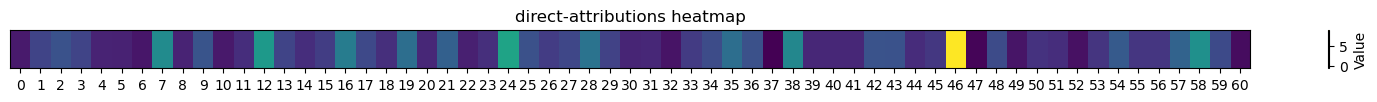

In [35]:
direct_attrib_np = attrib_dict["direct_attributions"].squeeze().detach().cpu().numpy()
tensor_2d = direct_attrib_np.reshape(1, -1)

plt.figure(figsize=(20, 0.5))
plt.imshow(tensor_2d, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('direct-attributions heatmap')
plt.yticks([]) 
plt.xticks(range(len(direct_attrib_np)))
plt.show()

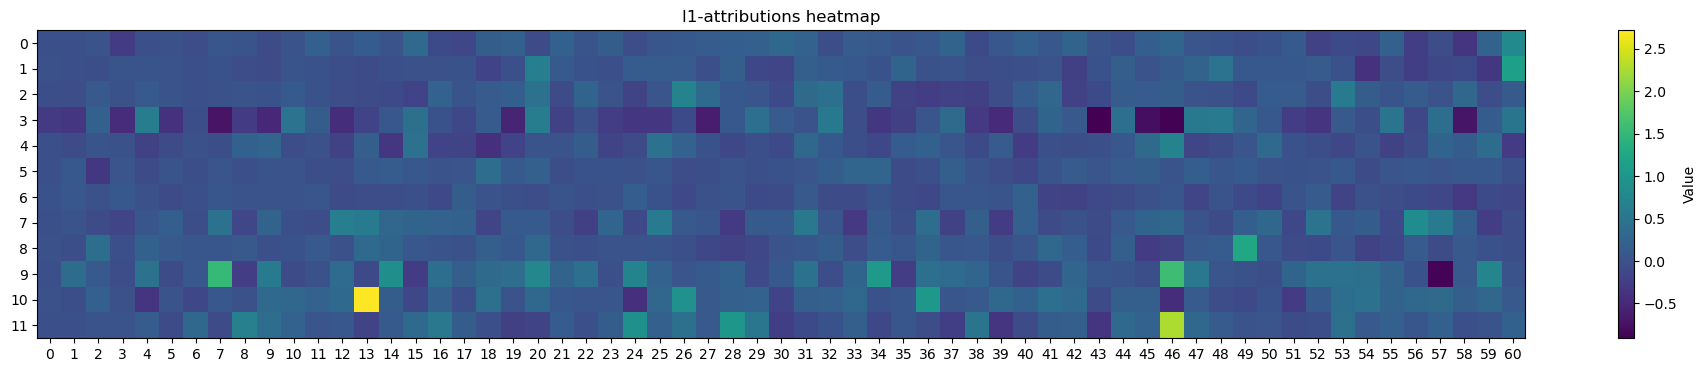

In [36]:
l1_attn_attribs_np = attrib_dict["l1_attributions"].detach().cpu().numpy().T

plt.figure(figsize=(24, 4))
plt.imshow(l1_attn_attribs_np, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('l1-attributions heatmap')
plt.xticks(np.arange(l1_attn_attribs_np.shape[1]))
plt.yticks(np.arange(l1_attn_attribs_np.shape[0]))
plt.show()

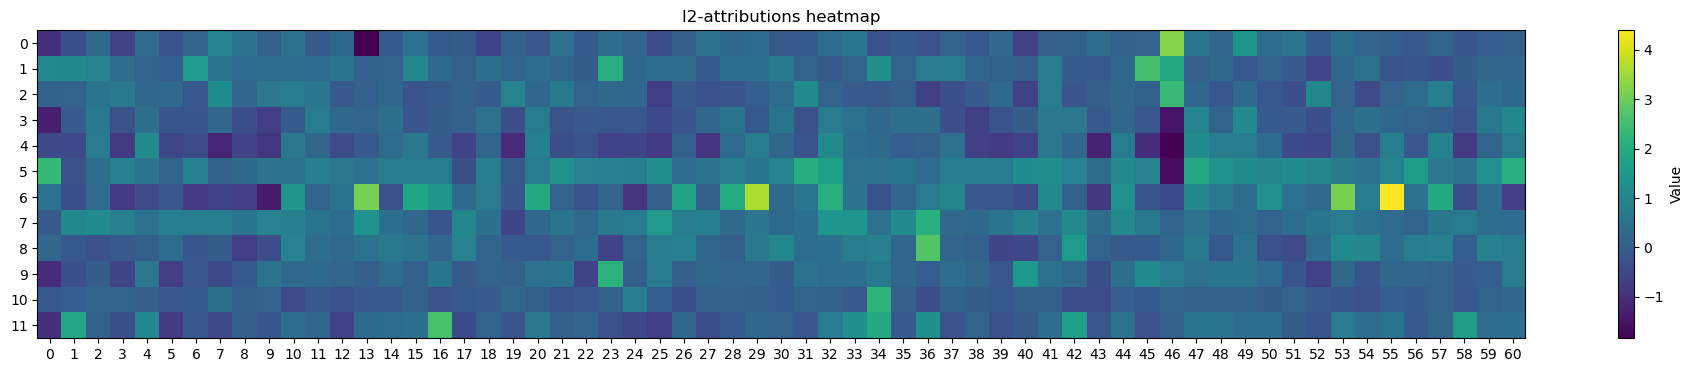

In [37]:
l2_attn_attribs_np = attrib_dict["l2_attributions"].detach().cpu().numpy().T

plt.figure(figsize=(24, 4))
plt.imshow(l2_attn_attribs_np, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('l2-attributions heatmap')

# Set ticks at every position
plt.xticks(np.arange(l2_attn_attribs_np.shape[1]))
plt.yticks(np.arange(l2_attn_attribs_np.shape[0]))

plt.show()

In [38]:
def generate_repeated_tokens(model, seq_len, batch=1):
    prefix = (torch.ones(batch, 1) * model.tokenizer.bos_token_id).long()
    rep_tokens_half = torch.randint(0, model.cfg.d_vocab, (batch, seq_len), dtype=torch.int64)
    rep_tokens = torch.cat([prefix, rep_tokens_half, rep_tokens_half], dim=-1).to("cuda")
    return rep_tokens

def run_and_cache_model_repeated_tokens(model, seq_len, batch=1):
    rep_tokens = generate_repeated_tokens(model, seq_len, batch)
    rep_logits, rep_cache = model.run_with_cache(rep_tokens)
    return rep_tokens, rep_logits, rep_cache


In [39]:
rep_tokens, rep_logits, rep_cache = run_and_cache_model_repeated_tokens(attn_model, seq_len=30)

with torch.inference_mode():
    rep_embed = rep_cache["embed"]
    rep_l1_results = rep_cache["result", 0]
    rep_l2_results = rep_cache["result", 1]
    rep_attrib_dict = logit_attribution(rep_embed[0], rep_l1_results[0], rep_l2_results[0], attn_model.W_U, rep_tokens[0], return_type="dict")

In [40]:
# torch.testing.assert_close(rep_attrib_dict["l1_attributions"], rep_attrib_dict["l2_attributions"], atol=1e-3, rtol=0)

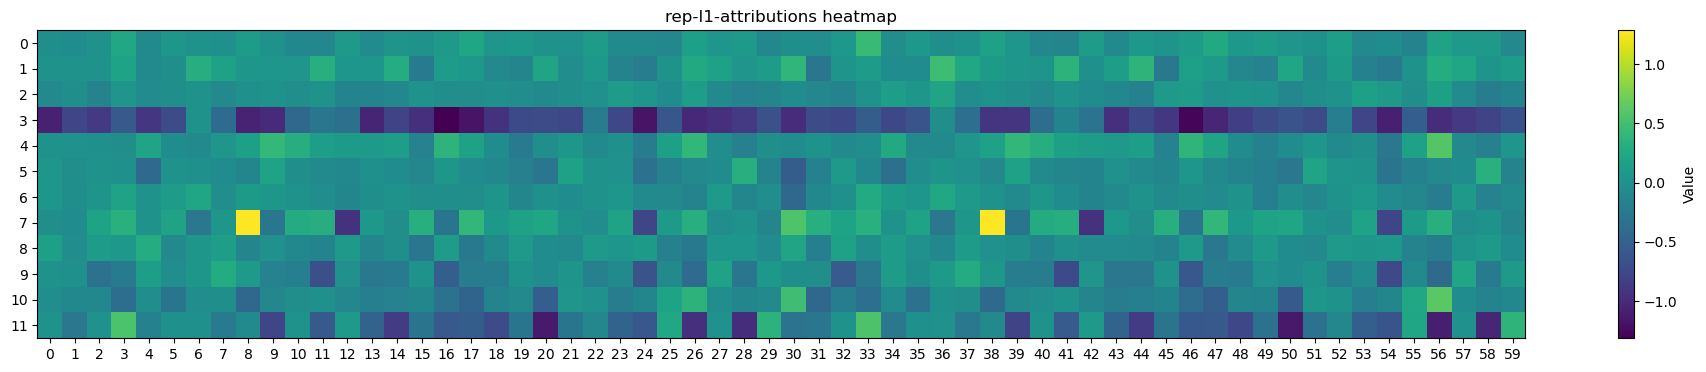

In [41]:
rep_l1_attn_attribs_np = rep_attrib_dict["l1_attributions"].detach().cpu().numpy().T

plt.figure(figsize=(24, 4))
plt.imshow(rep_l1_attn_attribs_np, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('rep-l1-attributions heatmap')
plt.xticks(np.arange(rep_l1_attn_attribs_np.shape[1]))
plt.yticks(np.arange(rep_l1_attn_attribs_np.shape[0]))
plt.show()

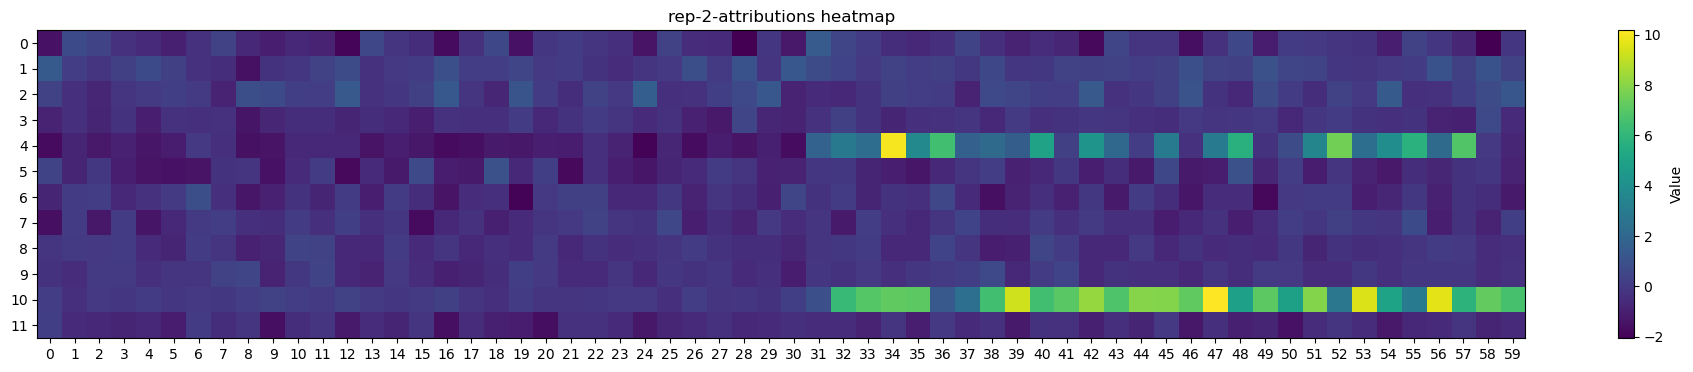

In [42]:
rep_l2_attn_attribs_np = rep_attrib_dict["l2_attributions"].detach().cpu().numpy().T

plt.figure(figsize=(24, 4))
plt.imshow(rep_l2_attn_attribs_np, cmap='viridis', aspect='auto')
plt.colorbar(label='Value')
plt.title('rep-2-attributions heatmap')
plt.xticks(np.arange(rep_l2_attn_attribs_np.shape[1]))
plt.yticks(np.arange(rep_l2_attn_attribs_np.shape[0]))
plt.show()

In [43]:
# Intervening on Activations - zero ablation

In [45]:
def zero_ablation_hook(attn_out, hook, ablation_head_index):
    attn_out[:, :, ablation_head_index, :] = 0.0
    return attn_out